In [1]:
import os, sys, time
import eli5
import pandas as pd
import pandas as pd
from eli5.sklearn import PermutationImportance
sys.path.append("..")

from src.constants import *
from src.weather import weather_data
from src.common_tools import load_obj, save_obj
from src.modeling.model_beta import beta_modeling
from src.modeling.model_alpha import alpha_modeling
from src.weather.weather_data import get_weather_data
from src.modeling.model_beta import non_crash_data_gen
from src import ups_data_loader, preprocessing, ups_plotting
from src.modeling.model_complete import model_full, model_demo

pd.set_option('display.max_columns', None)

### Data Collection and Generation Overview

<img src="static/notebook_ims/model_overviewC.png" width="750"/>

### 1.1 Generates Representative Non-Crash Data to Match Published Traffic Distributions and Histortical AADT
_____________

In [100]:
# load crash data
df_crash = ups_data_loader.load_crash_and_weather(CRASH_DATA_FILE_NAME)
# load street data
road_info = pd.read_csv(ROAD_DATA_PATH, low_memory=False)

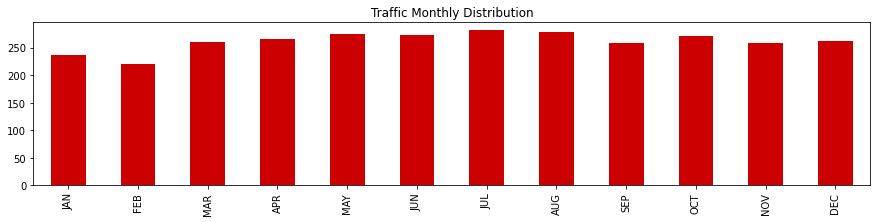

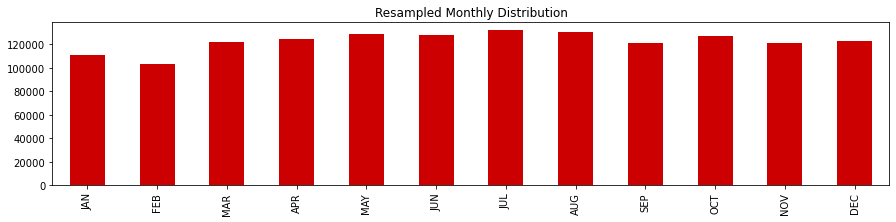

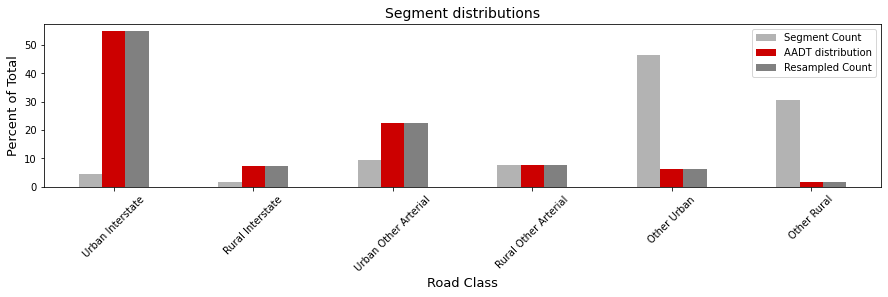

,STR_UNQ_ID,AADT_DESGN,RU_F_SYSTE,fClassSimp,weights,month,weights,day,hour,year
0,123898,25854,U3,U4,0.000003,2,0.011416,0,15,2018
1,92006,37464,R1,R1,0.000005,6,0.008956,3,10,2020


In [101]:
# load monthly traffic data
_, month_distri = non_crash_data_gen.load_statistical_traffic_disto(
    PUBISHED_TRAFFIC_DATA_MONTHLY_FILE_NAME)
# load hourly traffic data
df_traffic_by_hour, weekday2num = non_crash_data_gen.load_hourly_statistical_traffic_disto(
    PUBISHED_TRAFFIC_DATA_HOURLY_FILE_NAME)
df_non_crash_street_dates = non_crash_data_gen.main(df_crash, road_info, month_distri,
                                           df_traffic_by_hour, weekday2num)
df_non_crash_street_dates.head(2)

### 1.2 Match Representative Non-Crash Data to Real Weather Data
___________________
##### 1.2.1 Preprocessing

In [102]:
# laod non_crash data that matches length of the crash data with correct ditrobutions
df_non_crash_street_dates = pd.read_csv(ROAD2WEATHER2DATE_PATH)
df_non_crash_street_dates['NonCrashIDX'] = df_non_crash_street_dates.index
# load street data
road_info = pd.read_csv(ROAD_DATA_PATH, low_memory=False)
# convert to geo
road_info = weather_data.geo_convert(road_info)
road_info = road_info[['STR_UNQ_ID','Latitude','Longitude']]

uniqueST = list(df_non_crash_street_dates.STR_UNQ_ID.value_counts().index)
road_info = road_info[road_info['STR_UNQ_ID'].isin(uniqueST)]
# get weather data pickles
stid2lat = preprocessing.dict_from_cols(road_info, 'STR_UNQ_ID', 'Latitude')
stid2long = preprocessing.dict_from_cols(road_info, 'STR_UNQ_ID', 'Longitude')
df_non_crash_street_dates['Longitude'] = df_non_crash_street_dates.STR_UNQ_ID.map(lambda x: stid2long[int(x)])
df_non_crash_street_dates['Latitude'] = df_non_crash_street_dates.STR_UNQ_ID.map(lambda x: stid2lat[int(x)])
df_non_crash_street_dates.head(2)

,STR_UNQ_ID,AADT_DESGN,RU_F_SYSTE,fClassSimp,weights,month,weights.1,day,hour,year,NonCrashIDX,Longitude,Latitude
0,123898,25854,U3,U4,0.000003,2,0.011416,0,15,2018,0,-99.129351,30.057231
1,92006,37464,R1,R1,0.000005,6,0.008956,3,10,2020,1,-98.538838,32.496451


##### 1.2.2 Plotting crash and non-crash

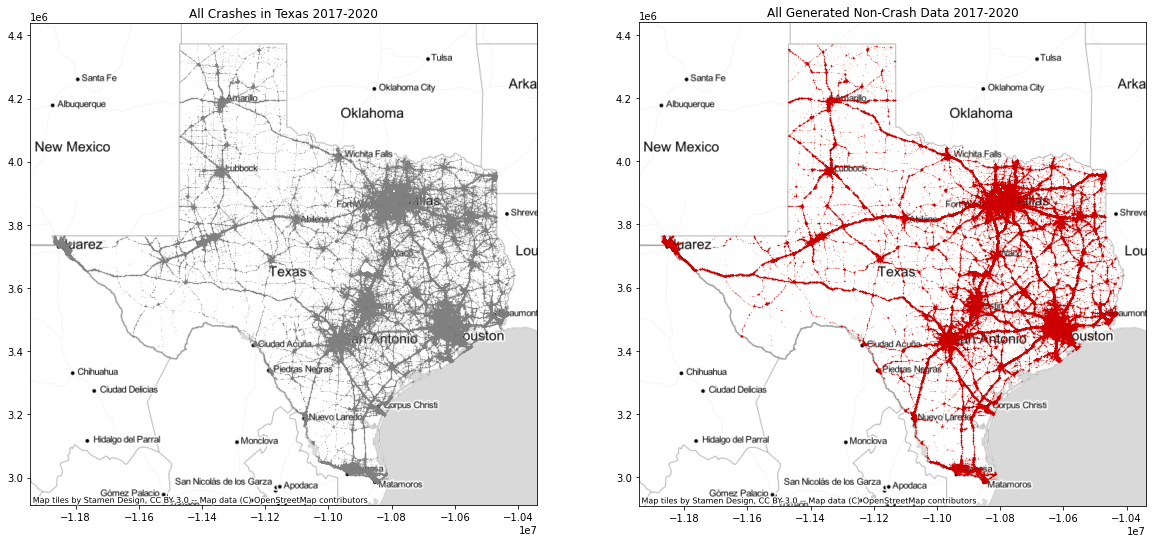

In [103]:
# plot generated dataframe
df_c_geo = ups_data_loader.load_all_tx_crash_data()
ups_plotting.plot_c_cn_points(df_c_geo, df_non_crash_street_dates)

##### 1.2.3 Weather Data Collection
Weather data is matched to both no crash and crash data. By implementing the granular local weather stations throughout Texas this project is able to match every collision/event to weather data within a 15-minute time interval.

<img src="static/notebook_ims/weatherBoth.PNG" width="900"/>

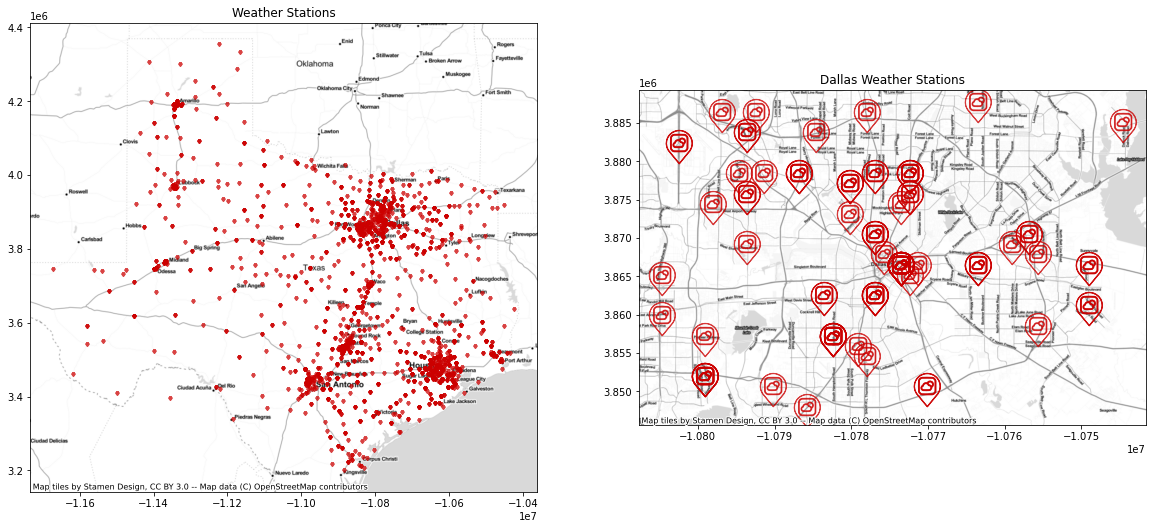

In [104]:
ups_plotting.plot_weather_stations()

In [105]:
COLLECT_WEATHER_DATA = None
if COLLECT_WEATHER_DATA:
    # collect and save raw weather
    weather_data.collect_raw_weather_data(df_non_crash_street_dates, start_val=0, stid2lat=stid2lat, stid2long=stid2long)
    # load waether obj and process the data and add it to a csv that can be joined with the non-crash data
    dicts, csvs = os.listdir(f'obj/{PATH2WEATHER_OBJ_DIR}/data'), os.listdir(f'{PATH2OUTPUT_CSV_NC_DIR}')
    dicts.sort()
    CSVs.sort()
    weather_data.convert_raw_weather_obj2csv(dicts, csvs, update_iter=1000)

### 2. Modeling Training
___________________

<img src="static/notebook_ims/UPS_part_two.drawio.png" width="650"/>

##### 2.1 Crash Probability Prediction (Model Alpha)

Count of mismatching columns: 0


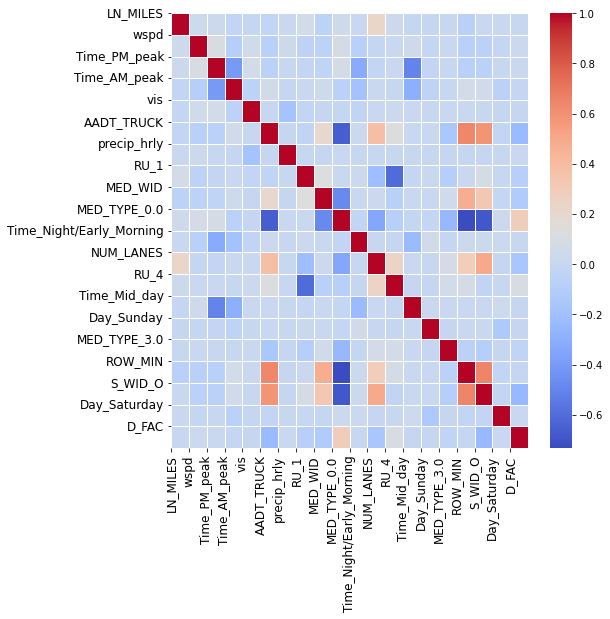

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8625615	best: 0.8625615 (0)	total: 616ms	remaining: 10m 15s
200:	test: 0.8793257	best: 0.8793257 (200)	total: 1m 20s	remaining: 5m 21s
400:	test: 0.8834453	best: 0.8834453 (400)	total: 2m 40s	remaining: 3m 59s
600:	test: 0.8854098	best: 0.8854098 (600)	total: 3m 58s	remaining: 2m 38s
800:	test: 0.8868177	best: 0.8868177 (800)	total: 5m 16s	remaining: 1m 18s
999:	test: 0.8879816	best: 0.8879816 (999)	total: 6m 34s	remaining: 0us

bestTest = 0.8879816155
bestIteration = 999

Model: Model_Alpha Save to: data/models/Model_Alpha.pkl


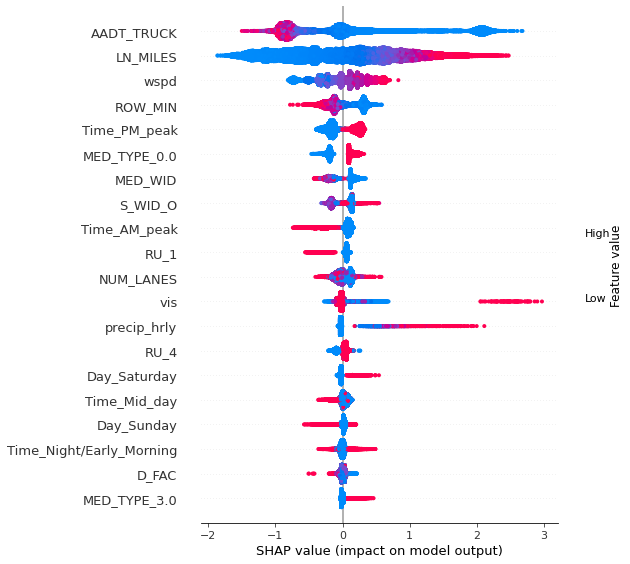

Weight,Feature
0.0829 ± 0.0008,AADT_TRUCK
0.0641 ± 0.0005,LN_MILES
0.0148 ± 0.0002,wspd
0.0055 ± 0.0002,Time_PM_peak
0.0052 ± 0.0004,MED_WID
0.0047 ± 0.0004,ROW_MIN
0.0044 ± 0.0005,MED_TYPE_0.0
0.0036 ± 0.0000,vis
0.0035 ± 0.0004,Time_AM_peak
0.0035 ± 0.0002,NUM_LANES


In [106]:
# load and process crash and non-crash data
df_C, df_NC = alpha_modeling.load_preprocess(CLEANED_C_FILE_PATH, CLEANED_NC_FILE_PATH)
df_C, df_NC = alpha_modeling.drop_check_for_missing(df_C, df_NC)
perm_alpha, cols, _, _ = alpha_modeling.main(df_C, df_NC)
eli5.show_weights(perm_alpha, feature_names=cols, top=100)

##### 2.2 Collision Severity Class Prediction (Model Beta)

<img src="static/notebook_ims/crash_cost.png" width="400"/>

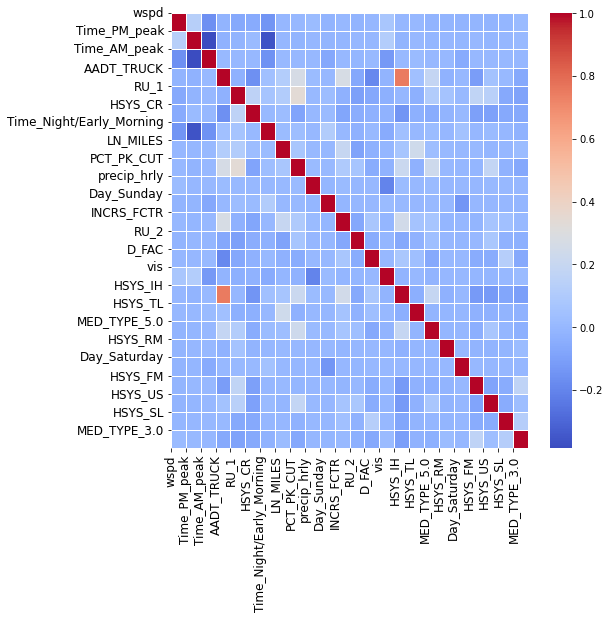

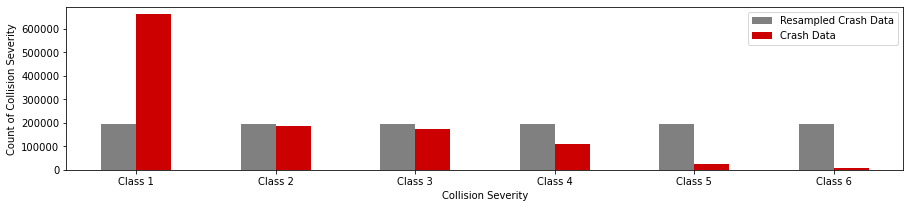

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6405304	best: 0.6405304 (0)	total: 1.94s	remaining: 32m 21s
200:	test: 0.6548972	best: 0.6548972 (200)	total: 5m 49s	remaining: 23m 9s
400:	test: 0.6587153	best: 0.6587153 (400)	total: 11m 33s	remaining: 17m 15s
600:	test: 0.6603237	best: 0.6603237 (600)	total: 17m 24s	remaining: 11m 33s
800:	test: 0.6608605	best: 0.6608638 (799)	total: 23m 10s	remaining: 5m 45s
999:	test: 0.6610395	best: 0.6611062 (973)	total: 28m 46s	remaining: 0us

bestTest = 0.6611061741
bestIteration = 973

Shrink model to first 974 iterations.
Model: Model_Beta Save to: data/models/Model_Beta.pkl


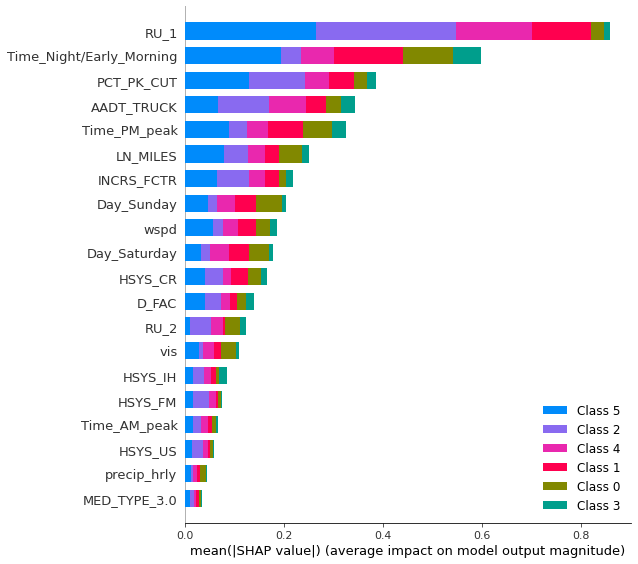

Weight,Feature
0.0212 ± 0.0008,AADT_TRUCK
0.0103 ± 0.0010,PCT_PK_CUT
0.0091 ± 0.0009,INCRS_FCTR
0.0087 ± 0.0008,RU_2
0.0066 ± 0.0008,HSYS_CR
0.0059 ± 0.0004,LN_MILES
0.0054 ± 0.0002,Time_Night/Early_Morning
0.0046 ± 0.0006,D_FAC
0.0037 ± 0.0005,RU_1
0.0036 ± 0.0003,HSYS_FM


In [2]:
# load crash data
df_crash = ups_data_loader.load_crash_and_weather(CRASH_DATA_FILE_NAME)
# map collisions 2 street labels
crash_map_file_name = 'cFromMatch2Roads-Crash2Roads.csv'
cMapCrash2Street = ups_data_loader.load_map_crash2segment(df_crash, crash_map_file_name)

# load street data
road_info = pd.read_csv(ROAD_DATA_PATH, low_memory=False)
road_info = preprocessing.cull_cols(road_info)
road_info = preprocessing.nan_thresh_drop(road_info, thresh=10000)
road_info_clean = beta_modeling.segment_data_preprocessing(df_crash, road_info)
perm_beta, cols, x_valid_beta, y_valid_beta = beta_modeling.main(road_info_clean)
eli5.show_weights(perm_beta, feature_names=cols, top=100)

### 3. Modeling Application
_________
<img src="static/notebook_ims/UPS_part_three.drawio.png" width="650"/>

##### 3.1 Load Complete Model

In [4]:
model_alpha, _ = ups_data_loader.load_model('Model_Alpha')
model_beta, _ = ups_data_loader.load_model('Model_Beta')

road_info = pd.read_csv(ROAD_DATA_PATH, low_memory=False)
road_info = preprocessing.nan_thresh_drop(road_info)
segment_map, lat_long2uni = preprocessing.preprocess_full_model_road(road_info)

trip1 = [37, 89, 108, 148, 215]

cost1 = model_full.fetch_trip_cost(model_alpha, model_beta, lat_long2uni, segment_map, trip1)

##### 3.2 Model Demo (Complete Model)

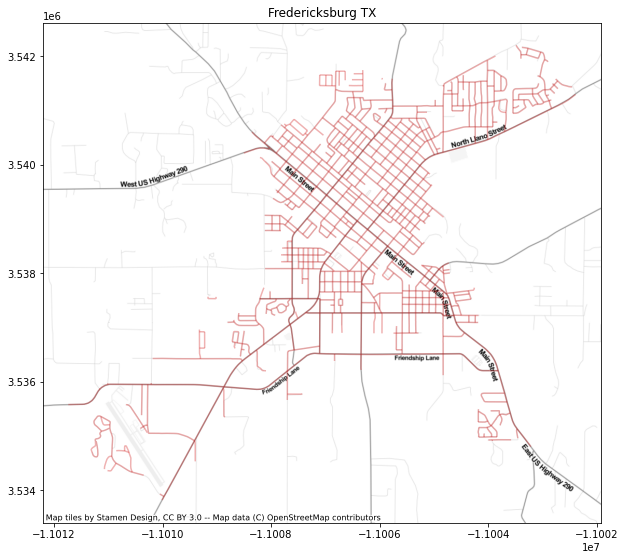

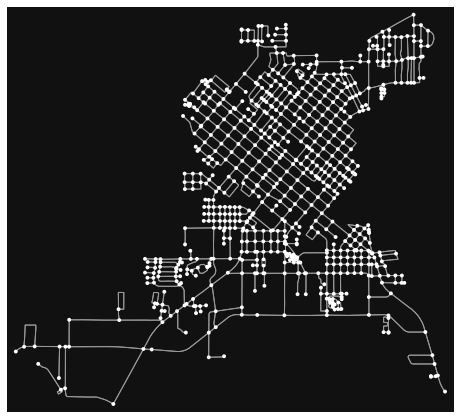

In [5]:
del road_info
fredericksburg = model_demo.fetch_map_demo_data()
g, map_df, nd = model_demo.fetch_demo_maps(fredericksburg)

This route incurs a risk cost of: $9.69


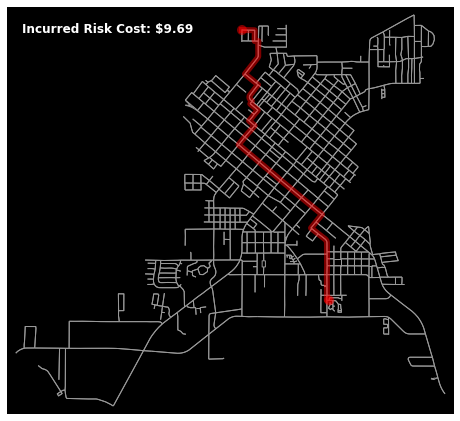

In [6]:
model_demo.random_map(g, map_df, nd, model_alpha, model_beta, lat_long2uni, segment_map)